![](https://admisiones.udemedellin.edu.co/wp-content/uploads/2021/01/logo-udemedellin.png)

# **Trazado de rayos en la propagación de ondas sísmicas usando el método de homotopía y continuación**

El objetivo será mostrar la implementación computacional de técnicas numéricas avanzadas aplicadas a trazado de rayos sísmicos que pueden manejar configuraciones bidimensionales complejas y medios con propiedades elásticas variables, teniendo consideraciones de velocidades de onda en medios compresivos (P-waves) y de Cizalla (S-Waves, Shear medium). Se disponen de herramientas teóricas como lo son la Ley de Snell, el método de Homotopía y continuación y el Método de Newton. Comencemos:

**¿Qué se necesita?**

* Ley de Snell, ecuaciones construidas para cada nodo interno que determina un sistema $\Phi(X, V)=0$
* Un primer rayo arbitrario
* Una signature conocida (dadas combinaciones de medios P y S)
* Arreglo de velocidades mapeadas a la signature conocida
* Una signature para determinar la continuación
* Arreglo de velocidades a realizar continuación
* Funciones de interfaces (dadas o interpolaciones)

Veamos la estructura básica del problema a resolver:

![](basic_example.png)

$$ $$

**Ley de Snell estructurada para este problema:**

$$ \phi_k = v_{k+1}\frac{ \left( x_k - x_{k-1} \right) + f'_{i_k}(x_k) \left( f_{i_k}(x_k) - f_{i_{k-1}}(x_{k-1}) \right) }{ \left[ \left( x_k - x_{k-1} \right)^2 + \left( f_{i_k}(x_k) - f_{i_{k-1}}(x_{k-1}) \right)^2 \right]^{1/2} } - v_k\frac{ \left( x_{k+1} - x_k \right) + f'_{i_k}(x_k) \left( f_{i_{k+1}}(x_{k+1}) - f_{i_k}(x_k) \right) }{ \left[ \left( x_{k+1} - x_k \right)^2 + \left( f_{i_{k+1}}(x_{k+1}) - f_{i_k}(x_k) \right)^2 \right]^{1/2} } = 0 $$

$$ $$

## **Estructura básica del algoritmo**

![](ray_tracing_process.png)

## **Demostración con un ejemplo básico del método**

In [8]:
import sys
sys.path.append('../source')

import numpy as np
import sympy as sp

from ray_surface import *
from HomotopyConstructions import *

Una vez importados los módulos construidos, procedemos con las construcciones iniciales:

In [11]:
# definiendo medios, interfaces de interaccion y velocidades en medios
media_trail = [1, 2, 3, 4, 4, 3, 2, 1]
interfaces = [0, 1, 2, 3, 4, 3, 2, 1, 0]
medium_velocities = { 'P':[2.44, 5.38, 7.50, 9.8],
                      'S':[1.71, 3.44, 5.6, 8.2] }

# necesario para calculos de derivadas analiticas
x = sp.symbols('x')

# formas de interfaces definidas, rectas paralelas
interface_functions = [ 0*x, 1.0 + 0*x, 2 + 0*x, 7 + 0*x, 9 + 0*x ]

# construyendo objetos Ray y Surface
myRay = Ray(media_trail, interfaces)
mySurface = Surface(interface_functions, myRay, medium_velocities)

# combinaciones de casos posibles para medios compresivo (Compressive, P-waves) y cizalla (Shear Waves)
mySurface.get_cases()[:6][:]

[['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
 ['P', 'P', 'P', 'P', 'P', 'P', 'P', 'S'],
 ['P', 'P', 'P', 'P', 'P', 'P', 'S', 'P'],
 ['P', 'P', 'P', 'P', 'P', 'P', 'S', 'S'],
 ['P', 'P', 'P', 'P', 'P', 'S', 'P', 'P'],
 ['P', 'P', 'P', 'P', 'P', 'S', 'P', 'S']]

In [3]:
# source and receiver locations on surface
xs, xr = 2, 6
all_points = 9  # internal points plus source and receiver

# first arbitrary ray construction
x_test = xs + np.arange(all_points) * ( xr - xs ) / ( all_points-1 )

# system construction with built arbitrary first ray
mySystem = SystemBuilder(x_test, mySurface)

# known and interest cases for continuation
interest_cases = [['P', 'P', 'P', 'P', 'P', 'P', 'P', 'P'],
                  ['S', 'S', 'S', 'S', 'S', 'S', 'S', 'S']]
x_test

array([2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ])

In [4]:
# getting solution of the system
sol = mySystem.newton_solve(interest_cases, tol=1e-3)
sol

array([2.        , 2.06695571, 2.20257972, 3.32363996, 4.        ,
       4.67636004, 5.79742028, 5.93304429, 6.        ])

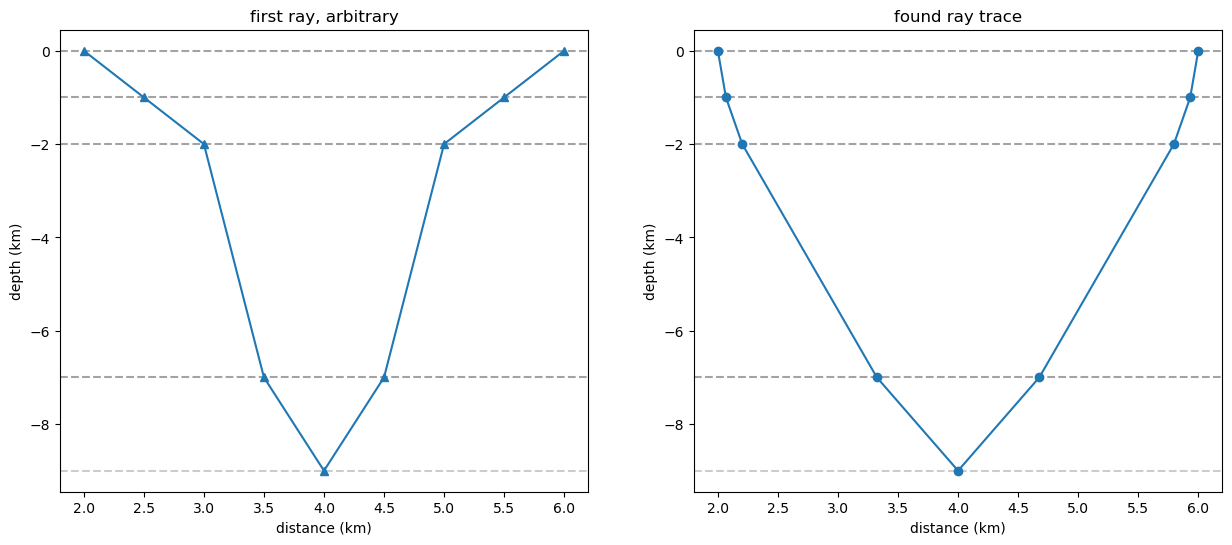

In [7]:
import matplotlib.pyplot as plt


# arbitrary ray
x_test = xs + np.arange(all_points) * ( xr - xs ) / ( all_points-1 )

# declaring depths
y = np.array([0, 1, 2, 7, 9, 7, 2, 1, 0])

# building figure
fig = plt.figure(figsize=(15,6))

for surf in y:
    plt.subplot(121)
    plt.axhline(y=-surf, color='k', linestyle='--', alpha=0.2)
    plt.subplot(122)
    plt.axhline(y=-surf, color='k', linestyle='--', alpha=0.2)

# first given ray
plt.subplot(121)
plt.title('first ray, arbitrary')
plt.xlabel('distance (km)'); plt.ylabel('depth (km)')
plt.plot(x_test, -y, marker='^')

# found approximated ray trace
plt.subplot(122)
plt.title('found ray trace')
plt.xlabel('distance (km)'); plt.ylabel('depth (km)')
plt.plot(sol, -y, marker='o')

plt.show()

## **Ejemplo para muchos rayos con `Seismic Unix`**

![](https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhBKXXA95wspd67zj4KVgDV_kLT8kSpLd-of7x1iS-L_j3vN5fD1QA3w9kkuqtrE-I7dQ1XkbREkb7IMCEsSKnbjitxTxu1HAzfXonsfImniI3PUY9KCYlOmrkZRJ5BXFBhUMNuJuypkcs/s1600/Triangulated_Sloth.png)

*Imagen extraída de https://totalcorner.blogspot.com/2014/01/seismic-modelling-by-using-seismic-unx.html*